Библиотеки


In [234]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Загрузка данных

In [235]:
data_dir  = '/kaggle/input/d/nmchos/curetoolsplit/curetcol/train'
datatest_dir='/kaggle/input/d/nmchos/curetoolsplit/curetcol/test'
classes = os.listdir(data_dir)
print(classes)

['sample45', 'sample51', 'sample50', 'sample46', 'sample42', 'sample40', 'sample53', 'sample52', 'sample43', 'sample47']


## Transformations:

Уменьшение размеров изображения до 128 на 128 и перевод их в ч/б

In [236]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

dataset = ImageFolder(data_dir, transform = transformations)
datasetest=ImageFolder(datatest_dir, transform = transformations)

Функция для вывода примера изображения из датасета

In [237]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    if img.shape[0] == 1:
        # Если изображение черно-белое (1 канал), добавляем cmap='gray'
        plt.imshow(img[0], cmap='gray')
    else:
        # Иначе, если это цветное изображение (3 канала), используем permute
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

Label: sample40 (Class No: 0)


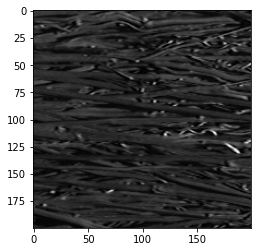

In [238]:
img, label = dataset[1]
show_sample(img, label)

# Loading and Splitting Data:

Попытка засидить все возможные вещи( но ощущение, что работает все с переменным успехом)

In [239]:
random_seed = 1
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

Пока что вырвал из тестовой части 50% на валидацию, возможны исправления

In [240]:

torch.manual_seed(1)
train_size = int(0.8 * len(dataset))
val_size = len(dataset)-train_size
train_ds, val_ds= torch.utils.data.random_split(dataset, [train_size, val_size])
test_ds=datasetest
len(train_ds), len(val_ds), len(test_ds),len(dataset)

(368, 92, 460, 460)

Batchsize

In [241]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

shuffle=True: Этот параметр определяет, будут ли данные перемешиваться перед каждой эпохой обучения. Перемешивание данных может быть полезным для предотвращения переобучения и улучшения обобщающей способности модели. Использую только для трейна, по дефолту значение FALSE

num_workers=4: Этот параметр определяет количество подпроцессов, которые будут использоваться для загрузки данных параллельно. Увеличение num_workers может ускорить загрузку данных, особенно если у вас есть доступные ядра процессора.

pin_memory=True: Если установлено в True, это параметр позволяет использовать "закрепленную" память (pinned memory) при передаче данных на GPU. Закрепленная память может улучшить скорость передачи данных между CPU и GPU.

In [242]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, num_workers = 4, pin_memory = True)
test_dl=DataLoader(test_ds,batch_size,num_workers = 4, pin_memory = True)

Демонстрация батчей

In [243]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

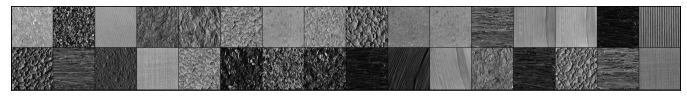

In [244]:
show_batch(train_dl)

# Model Base:

Базовый класс ImageClassificationBase

Метод training_step:

Принимает один батч данных (изображения и метки).
Подает изображения через модель и вычисляет предсказания (out).
Вычисляет функцию потерь с использованием кросс-энтропии (F.cross_entropy).
Возвращает значение функции потерь.
Метод validation_step:

Принимает один батч данных (изображения и метки).
Подает изображения через модель и вычисляет предсказания (out).
Вычисляет функцию потерь и точность с использованием определенной функции accuracy.
Возвращает словарь с val_loss и val_acc.
Метод validation_epoch_end:

Принимает список результатов validation_step для каждого батча.
Вычисляет среднюю потерю и точность по всем батчам.
Возвращает словарь с val_loss и val_acc для текущей эпохи.
Метод epoch_end:

Выводит в консоль информацию о потерях и точности на тренировочной и валидационной выборках после каждой эпохи.

In [245]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

Предобученная модель resnet50, в которой я меняют 1 входной слой, чтобы он принимал ч/б изображения.
за это отвечает эта строчка: 
self.network.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
строчка:self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) дообучает модель на моих данных

In [246]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

## Porting to GPU:

Т.К Pytorch хорошо работает с GPU, а мы ещё можем использовать вычислительные мощности Kaggle'а, то нужно с этим поработать
В этом коде определены несколько вспомогательных функций и классов, связанных с управлением устройством (CPU или GPU) в PyTorch:

get_default_device:

Эта функция возвращает устройство (torch.device) - 'cuda' (если GPU доступен) или 'cpu' (если GPU не доступен).
to_device:

Это функция, которая принимает тензор или список/кортеж тензоров и перемещает их на указанное устройство (device).
DeviceDataLoader:

Это обертка вокруг стандартного DataLoader, которая перемещает данные в указанное устройство при итерации по батчам.
__iter__ - для каждого батча возвращает батч, перемещенный на указанное устройство.
__len__ - возвращает количество батчей в оригинальном DataLoader.

In [247]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Training the Model:

@torch.no_grad():

Это декоратор, который предотвращает отслеживание градиентов PyTorch в блоке кода, который следует за ним. В данном случае, он используется в функции evaluate для предотвращения вычисления градиентов во время оценки модели на валидационном наборе данных.
evaluate функция:

Принимает модель и DataLoader для валидационного набора данных.
Переводит модель в режим оценки (model.eval()).
Использует torch.no_grad() для отключения вычисления градиентов во время оценки.
Итерируется по валидационному DataLoader, вычисляя результаты для каждого батча с использованием model.validation_step.
Вызывает model.validation_epoch_end для обработки результатов и возвращает их.
fit функция:

Принимает количество эпох (epochs), learning rate (lr), модель, тренировочный DataLoader (train_loader), валидационный DataLoader (val_loader) и функцию оптимизации (opt_func, по умолчанию torch.optim.Adam).
Инициализирует оптимизатор, используя переданный оптимизатор (opt_func).
Запускает цикл обучения на протяжении указанного числа эпох.
Для каждой эпохи:
Устанавливает модель в режим обучения (model.train()).
Итерируется по тренировочному DataLoader, выполняя тренировочные шаги (рассчитывая loss, обратное распространение, обновление параметров).
Устанавливает модель в режим оценки (model.eval()).
Вызывает evaluate для оценки модели на валидационном наборе.
Обновляет историю обучения и выводит информацию о текущей эпохе с использованием model.epoch_end.

In [248]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Отрисовка графиков аккураси и функции потерь

In [249]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [250]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [251]:
device = get_default_device()
device

device(type='cuda')

Даталоадеры и использование гпу

In [252]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(test_dl, device)
test_dl=DeviceDataLoader(test_dl,device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [253]:
model = to_device(ResNet(), device)

Полноценное обучение

In [254]:
num_epochs = 16
opt_func = torch.optim.Adam
lr = 5.5e-5
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 2.1512, val_loss: 2.3027, val_acc: 0.0979
Epoch 2: train_loss: 1.8607, val_loss: 2.3051, val_acc: 0.1021
Epoch 3: train_loss: 1.7179, val_loss: 2.2532, val_acc: 0.1729
Epoch 4: train_loss: 1.6323, val_loss: 2.0895, val_acc: 0.3701
Epoch 5: train_loss: 1.5786, val_loss: 1.7866, val_acc: 0.7021
Epoch 6: train_loss: 1.5391, val_loss: 1.5910, val_acc: 0.9187
Epoch 7: train_loss: 1.5104, val_loss: 1.5591, val_acc: 0.9333
Epoch 8: train_loss: 1.5036, val_loss: 1.5439, val_acc: 0.9438
Epoch 9: train_loss: 1.4955, val_loss: 1.5349, val_acc: 0.9500
Epoch 10: train_loss: 1.4889, val_loss: 1.5265, val_acc: 0.9604
Epoch 11: train_loss: 1.4895, val_loss: 1.5244, val_acc: 0.9500
Epoch 12: train_loss: 1.4889, val_loss: 1.5335, val_acc: 0.9396
Epoch 13: train_loss: 1.4945, val_loss: 1.5452, val_acc: 0.9208
Epoch 14: train_loss: 1.4876, val_loss: 1.5200, val_acc: 0.9479
Epoch 15: train_loss: 1.4803, val_loss: 1.5250, val_acc: 0.9333
Epoch 16: train_loss: 1.4859, val_loss: 1.5017, v

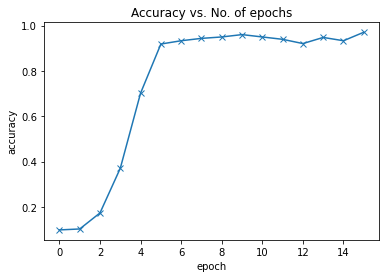

In [255]:
plot_accuracies(history)

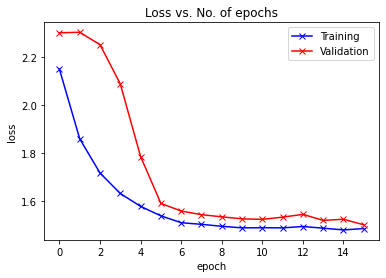

In [256]:
plot_losses(history)

In [257]:
@torch.no_grad()
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy
test_accuracy = test(model, test_dl)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Test accuracy: 96.96%


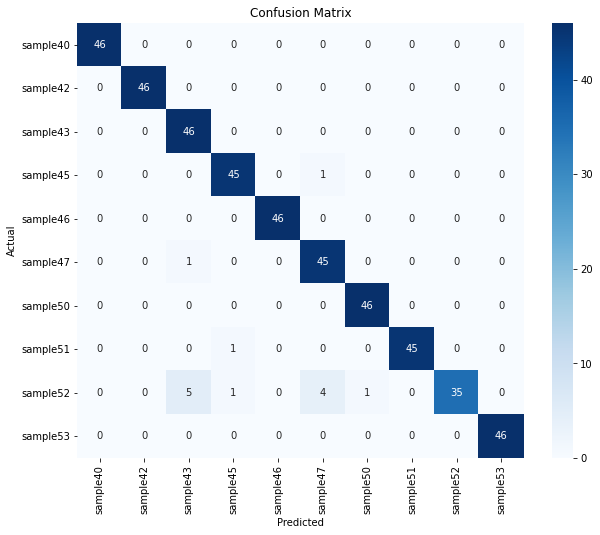

In [258]:
def get_confusion_matrix(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_predictions)
    return confusion_mat

# Используйте вашу модель и загрузчик тестовых данных
confusion_matrix_result = get_confusion_matrix(model, test_dl)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualizing Predictions:

In [259]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Рассмотрение примера на тестовых данных

Label: sample40 , Predicted: sample40


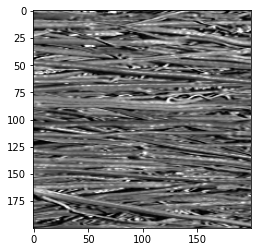

In [260]:
img, label = test_ds[5]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
plt.show()

Label: sample40 , Predicted: sample40


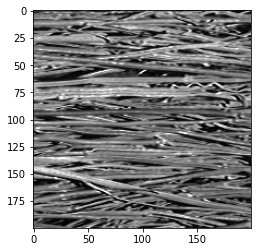

In [261]:
img, label = test_ds[23]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
plt.show()

Label: sample42 , Predicted: sample42


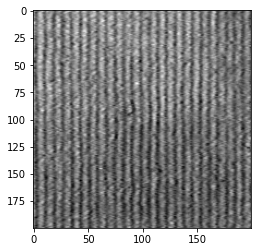

In [262]:
img, label = test_ds[55]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
plt.show()